## Create Conda environment

#### Run the below commands in terminal but ensure conda is installed or use ananconda prompt which is installed alongside the anaconda package installation.

--> *conda create -n mlflow_env python=3.9 ipykernel -y*; This creates a conda environment named mlfow_env (or whatever environment name is chosen) and installs python version 3.9 and an ipykernel inside this environment. Care must be taken when selecting a python version, otherwise, it could impede the import of MLFlow.

--> Activate the conda environment created in the previous step by running *conda activate mlfow_env* (or whatever environment name is chosen).

--> Add the newly created environment to the notebook as a **kernel** by running *python -m ipykernel install --user --name=mlfow_env* (or whatever environment name is chosen).

--> Create a notebook within the created environment by running *pip install notebook*

--> Install all required dependencies required for the project:

-  *pip install mlflow*
-  *pip install pandas*
-  *pip install numpy*
-  *pip install scikit-learn*
-  *pip install imblearn*
-  *pip install matplotlib*

--> Finally! open notebook running the command: *jupyter notebook*.

--> Click on *New* and choose the MLFlow **environment** you've just created.

In [219]:
!python --version

Python 3.9.19


In [220]:
import sys
print(sys.executable)

C:\Users\TFakorede\AppData\Local\anaconda3\envs\envname\python.exe


## Using Logistic Regression

#### Install all required dependencies required for the project

In [359]:
import spacy
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,RandomizedSearchCV,GridSearchCV)
from sklearn import metrics
from sklearn.metrics import (accuracy_score,precision_score,recall_score,
log_loss,f1_score,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay,classification_report)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path

In [223]:
!python -m spacy info


============================== Info about spaCy ==============================

spaCy version    3.7.5                         
Location         C:\Users\TFakorede\AppData\Local\anaconda3\envs\envname\lib\site-packages\spacy
Platform         Windows-10-10.0.19045-SP0     
Python version   3.9.19                        
Pipelines        en_core_web_sm (3.7.1)        



#### Create train/test datasets from human/animal datasets

In [224]:
#@title Create train/test datasets from human/animal datasets { form-width: "20%" }
animal = pd.read_csv('excludes_Animal_2200.csv')
human = pd.read_csv('includes_human_2400.csv')

#add target variable
animal['target'] = 0
human['target'] = 1

print(animal.columns)
print(human.columns)

#combine & shuffle the datasets
combined_data = pd.concat([animal, human], axis=0)
shuffled_combined_df = combined_data.sample(frac=1).reset_index(drop=True)

#create a 80-20 split from it
training, testing = train_test_split(shuffled_combined_df, test_size=0.2, random_state=42)

Index(['Title', 'Abstract', 'Primary Author', 'Journal', 'Year', 'Volume',
       'Issue', 'Pages', 'Comments', 'Eppi ID', 'target'],
      dtype='object')
Index(['Title', 'Abstract', 'Primary Author', 'Journal', 'Year', 'Volume',
       'Issue', 'Pages', 'Comments', 'Eppi ID', 'target'],
      dtype='object')


#### File settings to get started

In [225]:
#@title File settings to get started  { form-width: "20%" }

#@markdown Please ensure the training.csv and testing.csv are uploaded and execute this cell by pressing the _Play_ button
#@markdown on the left

#@markdown The training.csv and testing.csv files should have 'title', optional 'abstract' fields. Additionally the file should have a 'target' field
#@markdown which indicates whether the title/abstract is an include (coded as 1) or exclude (coded as 0)
TRAIN_PATH = 'training.csv'
TEST_PATH = 'testing.csv'

results_folder = 'RESULTS'
RESULTS_FOLDER = results_folder     #***user input
if not os.path.isdir(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)
RESULTS_PATH = Path(RESULTS_FOLDER)

#### Read in input data as separate training.csv and testing.csv. Ignore this block if human/animal data was uploaded above.

In [ ]:
#@title Read in input data as separate training.csv and testing.csv. **Ignore** this block if human/animal data was uploaded above { form-width: "20%" }
try:
    training = pd.read_csv(TRAIN_PATH)
    orig_colnames = training.columns
    print(orig_colnames)

    testing = pd.read_csv(TEST_PATH)

except Exception as e:
    print(e)
    raise

#### Read in input data

In [227]:
#@title Read in input data { form-width: "20%" }
rename_map = {'Title': 'title', 'Abstract': 'abstract'}
training.rename(columns = rename_map, inplace = True)
testing.rename(columns = rename_map, inplace = True)
print("Number of studies in the training dataset: " + str(training.shape[0]))
print("Number of studies in the training dataset: " + str(testing.shape[0]))

#rename the columns so that the relevant column names are 'title' and 'abstract'

try:
  training['title_orig'] = training['title']
  testing['title_orig'] = testing['title']
except Exception as e:
  print(e)
  print("Error- No title detected! Title is needed!")
  raise

# drop any duplicates based on 'title'
training.drop_duplicates(subset=['title'], inplace=True)
testing.drop_duplicates(subset=['title'], inplace=True)
print("Number of studies in the training dataset after de-dupe: " + str(training.shape[0]))
print("Number of studies in the testing dataset after de-dupe: " + str(testing.shape[0]))

training['titleabstract'] = training['title'] + " " + training['abstract']
training['titleabstract'] = training['titleabstract'].str.lower()

testing['titleabstract'] = testing['title'] + " " + testing['abstract']
testing['titleabstract'] = testing['titleabstract'].str.lower()

Number of studies in the training dataset: 3698
Number of studies in the training dataset: 925
Number of studies in the training dataset after de-dupe: 3692
Number of studies in the testing dataset after de-dupe: 925


#### Fit logistic regression model (in progress)

In [228]:
#@title Fit logistic regression model (in progress) { form-width: "20%" }

#A sklearn pipeline comprising of tf-idf vectorizer (using tri-gram) and logistic regression model. The parameters for logistic regression
#are taken from prior hyper-parameter tuning.
text_clf = Pipeline([
                ('tfidfvect', TfidfVectorizer(ngram_range = (3,3), stop_words = 'english')),
                ('clf', LogisticRegression(C=100, max_iter = 5000, solver = 'liblinear', penalty = 'l2', class_weight = 'balanced')),
               ])
y_train = training['target']
model = text_clf.fit(training['titleabstract'].astype(str),y_train)

#### Predict category and evaluate performance (in progress)

In [229]:
#@title Predict category and evaluate performance (in progress) { form-width: "20%" }

#Using the model that was fit to the training data above, evaluate the model's performance on test data.
data = testing['titleabstract'].astype(str)
y_test = testing['target']
yhat = model.predict(data)
yhat_probs = model.predict_proba(data)[:,1]
yhat_adjusted = np.zeros(data.shape[0], dtype=int)
THRESHOLD = 0.4
yhat_adjusted[yhat_probs >= THRESHOLD] = 1

report_dict = {}
decimal_places = 3
report_dict['Accuracy'] = round(accuracy_score(y_test, yhat_adjusted), decimal_places)
report_dict['Precision'] = precision_score(y_test,yhat_adjusted).round(decimal_places)
report_dict['Recall'] = recall_score(y_test, yhat_adjusted, average = 'binary').round(decimal_places)
report_dict['F1-Score'] = f1_score(y_test, yhat_adjusted).round(decimal_places)
report_dict['ROC_AUC'] = roc_auc_score(y_test, yhat_adjusted).round(decimal_places)
cm = confusion_matrix(y_test, yhat_adjusted)
FP = cm[0][1]
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
specificity = (TN / (TN+FP)).round(decimal_places)
FPR = (FP/(FP+TN)).round(decimal_places)
FNR = (FN/(FN+TP)).round(decimal_places)
report_dict['FPR'] = FPR
report_dict['FNR'] = FNR
report_dict['Specificity'] = specificity

print('Classification report:\n{}'.format(report_dict))


Classification report:
{'Accuracy': 0.806, 'Precision': 0.736, 'Recall': 0.979, 'F1-Score': 0.841, 'ROC_AUC': 0.799, 'FPR': 0.381, 'FNR': 0.021, 'Specificity': 0.619}


## Using Random Forest Classifer.

#### Data Preprocessing

In [350]:
#@title Basic Preprocessing { form-width: "20%" }

# Load dataset
animal = pd.read_csv('excludes_Animal_2200.csv')
human = pd.read_csv('includes_human_2400.csv')

# prompt: shape of the df
(animal.shape), (human.shape)
#add target variable
animal['target'] = 0
human['target'] = 1

In [232]:
animal.isna().sum(), human.isna().sum()

(Title                0
 Abstract            61
 Primary Author       4
 Journal              0
 Year                 0
 Volume              30
 Issue              687
 Pages              190
 Comments          2212
 Eppi ID              0
 target               0
 dtype: int64,
 Title                0
 Abstract           410
 Primary Author       0
 Journal              0
 Year                 2
 Volume              25
 Issue              113
 Pages                6
 Comments          2411
 Eppi ID              0
 target               0
 dtype: int64)

In [234]:
animal.columns, human.columns

(Index(['Title', 'Abstract', 'Primary Author', 'Journal', 'Year', 'Volume',
        'Issue', 'Pages', 'Comments', 'Eppi ID', 'target'],
       dtype='object'),
 Index(['Title', 'Abstract', 'Primary Author', 'Journal', 'Year', 'Volume',
        'Issue', 'Pages', 'Comments', 'Eppi ID', 'target'],
       dtype='object'))

In [235]:
# Deleting unwanted columns
human.drop(columns=['Primary Author', 'Journal', 'Year', 'Volume',
       'Issue', 'Pages', 'Comments', 'Eppi ID', 'target'], inplace=True)
animal.drop(columns=['Primary Author', 'Journal', 'Year', 'Volume',
       'Issue', 'Pages', 'Comments', 'Eppi ID', 'target'], inplace=True)
human.columns

Index(['Title', 'Abstract'], dtype='object')

In [236]:
animal.columns.shape

(2,)

In [237]:
animal.isna().sum()

Title        0
Abstract    61
dtype: int64

In [238]:
human.isnull().sum()

Title         0
Abstract    410
dtype: int64

In [239]:
animal.dropna(inplace=True)
animal.isna().sum()

Title       0
Abstract    0
dtype: int64

In [240]:
human.dropna(inplace=True)
human.isna().sum()

Title       0
Abstract    0
dtype: int64

In [241]:
animal['label'] = 0
human['label'] = 1

In [242]:
#Pretty balanced
animal.shape, human.shape

((2151, 3), (2001, 3))

In [243]:
#combine & shuffle the datasets
combined_df = pd.concat([animal, human], axis=0)
shuffled_combined_df = combined_df.sample(frac=1).reset_index(drop=True)

print(shuffled_combined_df.shape)
# shuffled_combined_df.head()

(4152, 3)


#### Read in input data

In [244]:
# rename the columns so that the relevant column names are 'title' and 'abstract'
rename_map = {'Title': 'title', 'Abstract': 'abstract'}
shuffled_combined_df.rename(columns = rename_map, inplace = True)
print("Number of studies in the training dataset: " + str(shuffled_combined_df.shape[0]))


try:
  shuffled_combined_df['title_orig'] = shuffled_combined_df['title']
except Exception as e:
  print(e)
  print("Error- No title detected! Title is needed!")
  raise


# drop any duplicates based on 'title'
shuffled_combined_df.drop_duplicates(subset=['title'], inplace=True)
print("Number of studies in the training dataset after de-dupe: " + str(shuffled_combined_df.shape[0]))

shuffled_combined_df['titleabstract'] = shuffled_combined_df['title'] + " " + shuffled_combined_df['abstract']
shuffled_combined_df['titleabstract'] = shuffled_combined_df['titleabstract'].str.lower()


#sanity check
shuffled_combined_df.columns

Number of studies in the training dataset: 4152
Number of studies in the training dataset after de-dupe: 4148


Index(['title', 'abstract', 'label', 'title_orig', 'titleabstract'], dtype='object')

#### Text Preprocessing

In [245]:
# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

In [246]:
#lemmatization
def lemmatization(titleabstract):
    doc = nlp(titleabstract)
    lemmalist = [word.lemma_ for word in doc]
    return " ".join(lemmalist)

In [247]:
shuffled_combined_df['lemma'] = shuffled_combined_df['titleabstract'].apply(lemmatization)

In [248]:
# shuffled_combined_df.head()

In [249]:
def remove_stopwords(titleabstract):
    doc = nlp(titleabstract)
    no_stopwords = [word.text for word in doc if not word.is_stop]
    return " ".join(no_stopwords)

In [250]:
shuffled_combined_df['stopwords'] = shuffled_combined_df['lemma'].apply(remove_stopwords)

In [256]:
# shuffled_combined_df.head()

#### Train-Test Split: Splits the data into training and test sets.

In [257]:
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target (y)
def custom_train_test_split(shuffled_combined_df):
    X = shuffled_combined_df['stopwords']
    y = shuffled_combined_df['label']

    # X.head()

    # Split the dataset into training and test sets
    # create a 80-20 split from it
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42) #**stratify = y
    return train_X, test_X, train_y, test_y

In [258]:
train_X, test_X, train_y, test_y = custom_train_test_split(shuffled_combined_df)
#train_test_split(shuffled_combined_df)

#### Initialize the Random Forest classifier

In [259]:
def training_basic_classifier(train_X, train_y):
    from math import pi
    basic_classifier = Pipeline([
    ('b_vectorizer', TfidfVectorizer()),
    ('b_classifier', RandomForestClassifier(n_jobs = 1, random_state = 42)) # n_estimators = 100, max_depth = 10, min_samples_split = 2, min_samples_leaf = 1
    ])
    # Train the model
    basic_classifier.fit(train_X, train_y)

    return model

In [260]:
model = training_basic_classifier(train_X,train_y)

In [261]:
def predict_on_test_data(model, test_X):
    pred_y = model.predict(test_X)
    # basic_classifier.score(test_X, test_y) * 100
    return pred_y

In [262]:
pred_y = predict_on_test_data(model,test_X)

In [263]:
# pred_y

In [264]:
def predict_prob_on_test_data(model, test_X):
    pred_y = model.predict_proba(test_X)
    return pred_y

In [265]:
pred_prob_y = predict_prob_on_test_data(model,test_X) #model.predict_proba(X_test)

In [266]:
pred_prob_y

array([[0.03014555, 0.96985445],
       [0.04820649, 0.95179351],
       [0.26383241, 0.73616759],
       ...,
       [0.90772237, 0.09227763],
       [0.09139147, 0.90860853],
       [0.87389207, 0.12610793]])

In [267]:
test_y[:5]

149     1
1973    1
238     0
1052    0
308     0
Name: label, dtype: int64

In [268]:
def get_metrics(true_y, pred_y, pred_prob_y):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(true_y, pred_y)
    prec = precision_score(true_y, pred_y)
    recall = recall_score(true_y, pred_y)
    entropy = log_loss(true_y, pred_prob_y)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [269]:
run_metrics = get_metrics(test_y, pred_y, pred_prob_y)

In [270]:
print(f'{run_metrics}')

{'accuracy': 0.94, 'precision': 0.89, 'recall': 0.99, 'entropy': 0.2}


In [271]:
print(f'classification Report: {classification_report(test_y, pred)}')

classification Report:               precision    recall  f1-score   support

           0       0.53      0.52      0.53       443
           1       0.47      0.48      0.47       387

    accuracy                           0.50       830
   macro avg       0.50      0.50      0.50       830
weighted avg       0.50      0.50      0.50       830



In [272]:
def create_roc_auc_plot(clf, X_data, y_data):
    metrics.RocCurveDisplay.from_estimator(clf, X_data, y_data)
    plt.savefig('roc_auc_curve.png')

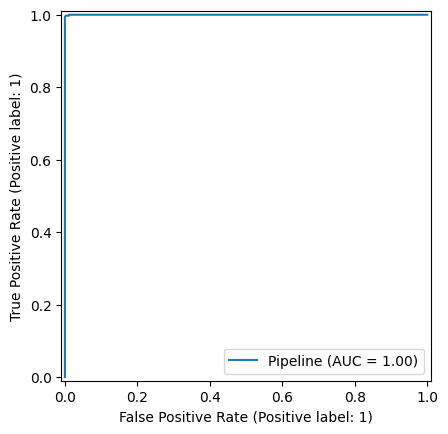

In [273]:
create_roc_auc_plot(basic_classifier, test_X, test_y)

In [274]:
def create_confusion_matrix_plot(clf, X_data, y_data):
    ConfusionMatrixDisplay.from_estimator(clf, X_data, y_data)
    plt.savefig('confusion_matrix.png')

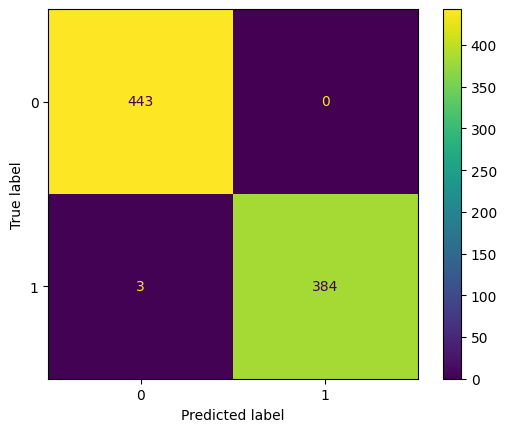

In [275]:
create_confusion_matrix_plot(basic_classifier, test_X, test_y)

In [364]:
def hyper_parameter_tuning(train_X, train_y):    
    # Define the pipeline: Creating a pipeline with the preprocessing steps and the classifier.
    hyper_classifier = Pipeline([
        ('h_vectorizer', TfidfVectorizer()),
        ('h_classifier', RandomForestClassifier()) # Added random_state for reproducibility
    ])

    
  # define random parameters grid
    n_estimators = [5,21,51,101] # number of trees in the random forest
    max_features = ['auto', 'sqrt'] # number of features in consideration at every split
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # minimum sample number to split a node
    min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
    bootstrap = [True, False] # method used to sample data points

    random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap
                  }
    
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, 
                                      param_distributions = random_grid,
                                      n_iter = 100, 
                                      cv = 5, 
                                      verbose=2, 
                                      random_state=35, 
                                      n_jobs = -1
                                     )
    
    model_tuning.fit(train_X, train_y)

    print ('Random grid: ', random_grid, '\n')
    # print the best parameters
    print ('Best Parameters: ', model_tuning.best_params_, ' \n')

    best_params = model_tuning.best_params_
    
    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']
    
    model_tuned = RandomForestClassifier(n_estimators = n_estimators, 
                                         min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf, 
                                         max_features = max_features,
                                         max_depth= max_depth, 
                                         bootstrap=bootstrap
                                        ) 
    
    # Fit the tuned model to the training data
    model_tuned.fit(train_X, train_y)
    
    return model_tuned, best_params

In [ ]:
h_model = hyper_parameter_tuning(train_X, train_y)

## MLFlow

#### Create Experiment

In [292]:
experiment_name = "basic_classifier" #***basic classifier
run_name="term_deposit"
run_metrics = get_metrics(test_y, pred_y, pred_prob_y)
print(run_metrics)

{'accuracy': 0.94, 'precision': 0.89, 'recall': 0.99, 'entropy': 0.2}


In [294]:
create_experiment(experiment_name, run_name, run_metrics, model, 'confusion_matrix.png', 'roc_auc_curve.png')

C:\Users\TFakorede\AppData\Local\anaconda3\envs\envname\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  
C:\Users\TFakorede\AppData\Local\anaconda3\envs\envname\lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  


Run - term_deposit is logged to Experiment - basic_classifier


#### Create another experiment after hyperparameter tuning; log the best set of parameters for which model gives the optimal performance.

In [347]:
experiment_name = "optimized model"
run_name="Random_Search_CV_Tuned_Model"
model_tuned, best_params = hyper_parameter_tuning(train_X, train_y)
run_params = best_params

pred_y = predict_on_test_data(model_tuned, test_X) #will return the predicted class
pred_prob_y = predict_prob_on_test_data(model_tuned, test_X) #model.predict_proba(X_test)
run_metrics = get_metrics(test_y, pred_y,  pred_prob_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\TFakorede\AppData\Local\anaconda3\envs\envname\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
260 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\TFakorede\AppData\Local\anaconda3\envs\envname\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\TFakorede\AppData\Local\anaconda3\envs\envname\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\TFakorede\AppData\Local\anaconda3\envs\envname\lib\site-

param_distributions: {'h_vectorizer__max_df': [0.75, 1.0], 'h_vectorizer__max_features': [None, 5000, 10000], 'h_vectorizer__ngram_range': [(1, 1), (1, 2)], 'h_classifier__n_estimators': [5, 21, 51, 101], 'h_classifier__max_features': ['auto', 'sqrt'], 'h_classifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'h_classifier__min_samples_split': [2, 6, 10], 'h_classifier__min_samples_leaf': [1, 3, 4], 'h_classifier__bootstrap': [True, False]}

Best Parameters: {'h_vectorizer__ngram_range': (1, 2), 'h_vectorizer__max_features': 5000, 'h_vectorizer__max_df': 0.75, 'h_classifier__n_estimators': 101, 'h_classifier__min_samples_split': 2, 'h_classifier__min_samples_leaf': 1, 'h_classifier__max_features': 'sqrt', 'h_classifier__max_depth': 70, 'h_classifier__bootstrap': False}
Best Score: 0.9731768703774375


ValueError: could not convert string to float: 'cellular imaging bactericidal mechanism green - synthesize silver nanoparticle human pathogenic bacteria . recent year , silver nanoparticle ( agnps ) attract significant attention medicinal , biomedical , pharmaceutical research owe valuable physicochemical antibacterial property . leaf sap extract ( lse ) aloe arborescen use active ingredient different biological application , include wound healing . study , investigate use lse a. arborescen reducing , stabilize cap agent produce agnps " green synthesis " ( g - agnps ) . objective study prepare , characterize evaluate potential g - agnps human pathogenic bacteria intend use treatment infected wound . mixture silver nitrate solution lse expose direct sunlight yield rapid color change colorless reddish - brown , indicate formation g - agnps . physicochemical characterization single particle inductively couple plasma mass spectrometry , high resolution transmission electron microscopy surface chemistry study ( fouri transform infrared spectroscopy x - ray diffraction ) reveal small size range 38+/-2 nm , smooth surface existence lse g - agnps . g - agnps possess good antibacterial activity pseudomonas aeruginosa staphylococcus aureus . flow cytometry study reveal increase percentage dead cell treat g - agnps cell membrane damage , far confirm confocal laser scan microscopy . , present study reveal novel g - agnps demonstrate effective antibacterial property gram - negative gram - positive bacterial strain great potential use treatment pathogen infected wound . copyright © 2017 elsevi b.v . right reserve .'

In [340]:
create_experiment(experiment_name,run_name,run_metrics,model_tuned,'confusion_matrix.png', 'roc_auc_curve.png',run_params)

NameError: name 'model_tuned' is not defined

#### Function to create an experiment in MLFlow, log parameters, metrics, artifacts and files like images...

In [293]:
def create_experiment(experiment_name,run_name, run_metrics,model, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):
    import mlflow
    #mlflow.set_tracking_uri("http://localhost:5000") #uncomment this line if you want to use any database like sqlite as backend storage for model
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_materix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))

In [ ]:
#### Another experiment after hyperparameters tuning and log the best set of parameters for which model gives the optimal performance